In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
from collections import defaultdict, Counter
import _pickle as pickle
import random
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from scipy.stats import fisher_exact

In [2]:
demographic_matrix = pickle.load(open('data/demographic_matrix.p', 'rb'))
demographic_variables = pickle.load(open('data/demographic_variables.p', 'rb'))
datetime_matrix = pickle.load(open('data/datetime_matrix.p', 'rb'))
datetime_variables = pickle.load(open('data/datetime_variables.p', 'rb'))
diag_matrix = pickle.load(open('data/diag_matrix.p', 'rb'))
diag_variables = pickle.load(open('data/diag_variables.p', 'rb'))
negative_training_set = pickle.load(open('data/negative_training_set.p', 'rb'))
positive_training_set = pickle.load(open('data/positive_training_set.p', 'rb'))

In [3]:
full_matrix = []

for pat_enc_csn_id in positive_training_set:
    to_add = demographic_matrix[pat_enc_csn_id]
    to_add += datetime_matrix[pat_enc_csn_id]
    to_add += diag_matrix[pat_enc_csn_id]
    full_matrix.append(to_add)
    
for pat_enc_csn_id in negative_training_set:
    to_add = demographic_matrix[pat_enc_csn_id]
    to_add += datetime_matrix[pat_enc_csn_id]
    to_add += diag_matrix[pat_enc_csn_id]
    full_matrix.append(to_add)

In [4]:
Counter([len(i) for i in full_matrix])

Counter({1637: 9340})

In [5]:
full_variable_list = demographic_variables + datetime_variables[:-1] + diag_variables
len(full_variable_list)

1637

In [6]:
len(positive_training_set), len(negative_training_set)

(4670, 4670)

In [7]:
covid_non_covid_visits = [1 for i in range(4670)] + [0 for i in range(4670)]
len(covid_non_covid_visits), Counter(covid_non_covid_visits)

(9340, Counter({1: 4670, 0: 4670}))

In [8]:
full_matrix = np.array(full_matrix)

In [9]:
negative_testing_set = pickle.load(open('data/negative_eval_set.p', 'rb'))
positive_testing_set = pickle.load(open('data/positive_eval_set.p', 'rb'))

In [10]:
full_matrix_testing = []

for pat_enc_csn_id in positive_testing_set:
    to_add = demographic_matrix[pat_enc_csn_id]
    to_add += datetime_matrix[pat_enc_csn_id]
    to_add += diag_matrix[pat_enc_csn_id]
    full_matrix_testing.append(to_add)
    
for pat_enc_csn_id in negative_testing_set:
    to_add = demographic_matrix[pat_enc_csn_id]
    to_add += datetime_matrix[pat_enc_csn_id]
    to_add += diag_matrix[pat_enc_csn_id]
    full_matrix_testing.append(to_add)

In [11]:
covid_non_covid_visits_testing = [1 for i in range(4670)] + [0 for i in range(4670)]
len(covid_non_covid_visits_testing), Counter(covid_non_covid_visits_testing)

(9340, Counter({1: 4670, 0: 4670}))

In [12]:
full_matrix_testing = np.array(full_matrix_testing)

In [14]:
varaiable_sort_index_random = random.sample(range(0,1637), 1637)

In [17]:
training_oob_auroc_random = {}
training_auroc_random = {}
testing_auroc_random = {}


for d in tqdm(range(1,1638)):
    partial_matrix = full_matrix[:,varaiable_sort_index_random[:d]]
    partial_matrix_testing = full_matrix_testing[:,varaiable_sort_index_random[:d]]
    rf = RandomForestClassifier(n_estimators=200, random_state=1, oob_score=True)
    rf.fit(partial_matrix, covid_non_covid_visits)
    estimate_covid_oob = rf.oob_decision_function_[:,1]
    estimate_covid = rf.predict_proba(partial_matrix)[:,1]
    testing_covid = rf.predict_proba(partial_matrix_testing)[:,1]
    false_positive_rate, true_positive_rate, thresholds = roc_curve(covid_non_covid_visits, estimate_covid_oob)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    training_oob_auroc_random[d]=roc_auc
    false_positive_rate, true_positive_rate, thresholds = roc_curve(covid_non_covid_visits, estimate_covid)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    training_auroc_random[d]=roc_auc
    false_positive_rate, true_positive_rate, thresholds = roc_curve(covid_non_covid_visits_testing, testing_covid)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    testing_auroc_random[d]=roc_auc

100%|██████████| 1637/1637 [6:17:10<00:00, 13.82s/it]  


Text(0, 0.5, 'AUROC')

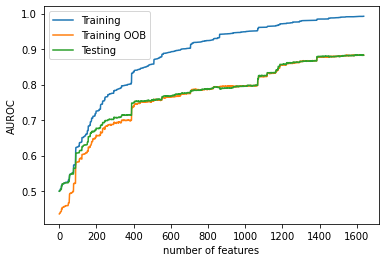

In [18]:
plt.plot(list(training_auroc_random.keys()), list(training_auroc_random.values()), label = 'Training')
plt.plot(list(training_oob_auroc_random.keys()), list(training_oob_auroc_random.values()), label = 'Training OOB')
plt.plot(list(testing_auroc_random.keys()), list(testing_auroc_random.values()), label = 'Testing')
plt.legend()
plt.xlabel('number of features')
plt.ylabel('AUROC')

In [19]:
pickle.dump(varaiable_sort_index_random, open('data/variable_sort_index_random.p', 'wb'))
pickle.dump(training_auroc_random, open('data/training_auroc_random.p', 'wb'))
pickle.dump(training_oob_auroc_random, open('data/training_oob_auroc_random.p', 'wb'))
pickle.dump(testing_auroc_random, open('data/testing_auroc_random.p', 'wb'))